http://www.nuforc.org/webreports/ndxevent.html

https://data.world/timothyrenner/ufo-sightings

In [4]:
from bs4 import BeautifulSoup as bsoup
from urllib.request import Request, urlopen
import urllib.error
import csv
import requests
import pandas as pd
import numpy as np
import time
import logging

import nltk
import re
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
!pip install contractions
import contractions
from wordcloud import WordCloud
import matplotlib.pyplot as plt

!pip install country_list
import country_list

logging.basicConfig(filename='sightings.log', format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S', level=logging.INFO)
logger = logging.getLogger()

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [21]:
def get_page(url):
    req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
    count = 0
    webpage = ""
    while count < 100:
        count += 1
        try:
            webpage = urlopen(req).read()
        except urllib.error.HTTPError as e:
            # Return code error (e.g. 404, 501, ...)
            logger.info('HTTPError: {}'.format(e.code))
            logger.info(f"Errored: {len(sightings)}; {url}")
            return None
        except urllib.error.URLError as e:
            # Not an HTTP-specific error (e.g. connection refused)
            logger.info('URLError: {}'.format(e.reason))
            time.sleep(15)
            continue
        except:
            logger.info(f"Errored: {len(sightings)}; {url}")
            time.sleep(15)
            continue
            logger.info(f"Trying again: {len(sightings)}; {url}")
        
        if len(webpage) > 0:
            break
        
        if count >= 100:
            return None

    #Create a beautiful soup object so we can work with the data
    soup = bsoup(webpage, 'html.parser')

    #Sanity check 
    return soup

In [22]:
def get_iterable_data(table):
    for c in table:
        yield c.getText()

In [23]:
def get_sighting_detail(url_string):
    detail_page = get_page(url_string)
    if detail_page is None:
        logger.info(f"No summary page: {url_string}")
        return "Summary detail page not found."
    detail_page = detail_page.find("tbody")
    if detail_page is None:
        return None
    rows = detail_page.find_all("tr")
    d = get_iterable_data(rows)
    next(d)
    return next(d)

In [24]:
def monthly_report_detail(url_string, col_names, sightings, remaining):
    # func_sightings = pd.DataFrame(columns = col_names)
    soup = get_page(url_string)
    temp = dict()

    results = soup.find_all('tr', attrs={'valign': 'TOP'})
    index = len(sightings)
    count = 0
    for result in results:
        if remaining > 0:
            remaining -= 1
            count += 1
            continue
        # print(f"Length: {len(sightings)}, index: {index}, count: {count}, remaining: {remaining}")
        table_cols = result.find_all('td')    
        col_text = get_iterable_data(table_cols)
        temp["Date_Time"] = next(col_text)
        temp["City"] = next(col_text)
        temp["State"] = next(col_text)
        temp["Shape"] = next(col_text)
        temp["Duration"] = next(col_text)
        temp["Summary"] = next(col_text)
        temp["Posted"] = next(col_text)
        temp["Detail_Link"] = "http://www.nuforc.org/webreports/" + result.find("a").get("href")
        temp["Detail_Summary"] = get_sighting_detail(temp["Detail_Link"])

        # func_sightings = func_sightings.append(temp, ignore_index = True)
        sightings.loc[index] = temp
        logger.info(f"Record added: {temp['Date_Time']} - {temp['City']}, {temp['State']}")
        print(f"Record added: {temp['City']}, {temp['State']}")
        index += 1
    return len(results)

In [25]:
def get_raw_sightings():
    url_string = "http://www.nuforc.org/webreports/ndxevent.html"
    monthly_report = get_page(url_string)
    monthly_report_list = monthly_report.find_all('tr', attrs={'valign': 'TOP'})
    # print(monthly_report_list)

    remaining = len(sightings)
    for report in monthly_report_list:
        cols = report.find_all("td")
        report_number = int(cols[1].getText())

        if remaining > report_number:
            remaining = remaining - report_number
            continue

        if remaining > 0:
            logger.info(f"Resuming: {len(sightings)}")

        monthly_report_url = "http://www.nuforc.org/webreports/" + report.find("a").get("href")
        logger.info(f"new report page: {monthly_report_url}; Sightings in page: {report_number}; Total: {len(sightings)}")
        sightings_added = monthly_report_detail(monthly_report_url, col_names, sightings, remaining)
        logger.info(f"added {sightings_added} sightings, total now {len(sightings)}")
        print(f"added {sightings_added} sightings, total now {len(sightings)}")

        sightings.to_pickle(file_name)

        remaining = 0

In [5]:
# col_names = ["Date_Time", "City", "State", "Shape", "Duration", "Summary", "Posted", "Detail_Link", "Detail_Summary"]
# sightings = pd.DataFrame(columns = col_names)
file_name = "sightings.pkl"
logger.info(f"Data read from {file_name}")
sightings = pd.read_pickle(file_name)

len(sightings)

97250

In [27]:
sightings.head()

,Date_Time,City,State,Shape,Duration,Summary,Posted,Detail_Link,Detail_Summary
0,4/23/21 06:30,Blackshear,GA,Circle,9 minutes,Very strange ((NUFORC Note: Rocket launch f...,4/23/21,http://www.nuforc.org/webreports/162/S162815.html,\nVery strangeI have recorded a video of this ...
1,4/23/21 06:00,Mechanicsville,VA,Circle,Seconds,Ball in the sky ((NUFORC Note: Rocket launc...,4/23/21,http://www.nuforc.org/webreports/162/S162814.html,\nBall in the skyObject appears as a white bal...
2,4/23/21 06:00,Vero Beach,FL,Light,5 minutes,I was driving and saw something strange in the...,4/23/21,http://www.nuforc.org/webreports/162/S162822.html,\nI was driving and saw something strange in t...
3,4/23/21 05:59,St. Augustine,FL,Light,3 minutes,2 extremely bright lights appeared over east c...,4/23/21,http://www.nuforc.org/webreports/162/S162824.html,\n2 extremely bright lights appeared over east...
4,4/23/21 05:58,Durham,NC,Cone,>5 minutes,A cone of light coming from the sky unlike any...,4/23/21,http://www.nuforc.org/webreports/162/S162819.html,\nA cone of light coming from the sky unlike a...


In [6]:
len(sightings[sightings["Detail_Summary"] == "Summary detail page not found."])

114

In [7]:
len(sightings[(sightings["Detail_Summary"].isnull())])

19

In [8]:
no_detail_summary_df = sightings[(sightings["Detail_Summary"].isnull()) | (sightings["Detail_Summary"] == "Summary detail page not found.")]
len(no_detail_summary_df)

133

In [31]:
no_detail_summary_df

,Date_Time,City,State,Shape,Duration,Summary,Posted,Detail_Link,Detail_Summary
13053,5/13/19 23:11,Oconomowoc,WI,Disk,2-3 minutes,"Circulating white light beneath a disk, slowly...",5/14/19,http://www.nuforc.org/webreports/146/S146109.html,Summary detail page not found.
13055,5/13/19 22:00,Rock Creek,MN,Circle,15 minutes,No blinking lights and they were flying together,5/14/19,http://www.nuforc.org/webreports/146/S146107.html,Summary detail page not found.
13058,5/13/19 20:27,Springfield,TN,Light,1 hour,I seen two lights do a barrel roll type move a...,5/14/19,http://www.nuforc.org/webreports/146/S146105.html,Summary detail page not found.
13062,5/13/19 16:30,Olive Branch,MS,Egg,20 minutes,Reflecting object in the sky slow moving. ((a...,5/14/19,http://www.nuforc.org/webreports/146/S146102.html,Summary detail page not found.
13065,5/13/19 08:15,Burlington/Billerica,MA,Changing,~3 minutes,Very bright circular floating ball - collapsed...,5/14/19,http://www.nuforc.org/webreports/146/S146089.html,Summary detail page not found.
13067,5/12/19 23:54,Chicago,IL,Circle,20 seconds,Large circular black disc over Chicago at nigh...,5/14/19,http://www.nuforc.org/webreports/146/S146090.html,Summary detail page not found.
13068,5/12/19 23:00,Mill Creek,WA,Changing,,I saw an object with a string of white lights ...,5/14/19,http://www.nuforc.org/webreports/146/S146099.html,Summary detail page not found.
13069,5/12/19 22:05,Vallejo,CA,Light,30 seconds,Two Connected Hovering Lights Above Garden.,5/14/19,http://www.nuforc.org/webreports/146/S146092.html,Summary detail page not found.
13070,5/12/19 22:00,Old Town,ME,Sphere,30 seconds,"Silent, orange, metallic sphere glides over ho...",5/14/19,http://www.nuforc.org/webreports/146/S146094.html,Summary detail page not found.
13072,5/12/19 22:00,Austin,TX,Unknown,20 minutes,Strange bright objects in Northwest Austin sky...,5/14/19,http://www.nuforc.org/webreports/146/S146096.html,Summary detail page not found.


In [32]:
count = 0
for index, row in no_detail_summary_df.iterrows():
    url = row.Detail_Link
    sighting_detail = get_sighting_detail(url)
    print(f"{count}, {row.Date_Time}: {sighting_detail}; {url}") 
    count += 1

0, 5/13/19 23:11: Summary detail page not found.; http://www.nuforc.org/webreports/146/S146109.html
1, 5/13/19 22:00: Summary detail page not found.; http://www.nuforc.org/webreports/146/S146107.html
2, 5/13/19 20:27: Summary detail page not found.; http://www.nuforc.org/webreports/146/S146105.html
3, 5/13/19 16:30: Summary detail page not found.; http://www.nuforc.org/webreports/146/S146102.html
4, 5/13/19 08:15: Summary detail page not found.; http://www.nuforc.org/webreports/146/S146089.html
5, 5/12/19 23:54: Summary detail page not found.; http://www.nuforc.org/webreports/146/S146090.html
6, 5/12/19 23:00: Summary detail page not found.; http://www.nuforc.org/webreports/146/S146099.html
7, 5/12/19 22:05: Summary detail page not found.; http://www.nuforc.org/webreports/146/S146092.html
8, 5/12/19 22:00: Summary detail page not found.; http://www.nuforc.org/webreports/146/S146094.html
9, 5/12/19 22:00: Summary detail page not found.; http://www.nuforc.org/webreports/146/S146096.html


KeyboardInterrupt: 

In [9]:
sightings = sightings[sightings['Summary'].str.contains('MADAR')==False]
sightings = sightings[sightings["Detail_Summary"] != "Summary detail page not found."]
sightings = sightings[(sightings["Detail_Summary"].isnull() == False)]
len(sightings)

95557

In [ ]:
# sightings[["Summary", "Detail_Summary"]].replace(to_replace='\\[\\n]', value=' ', inplace=True, regex=True)

In [10]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(w) for w in text.split(' ')])

def expand_contractions(text):
    expanded_words = []    
    for word in text.split():
        expanded_words.append(contractions.fix(word))   

    return ' '.join(expanded_words)

def regex_clean(text):
    """
    Applies some pre-processing on the given text.

    Steps :
    - Removing HTML tags
    - Removing punctuation
    - Lowering text
    """
    
    # remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # remove the characters [\], ['] and ["]
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)    
    
    # convert text to lowercase
    text = text.strip().lower()
    
    # replace punctuation characters with spaces
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)

    return text

def clean_text(text):
    stop = set(nltk.corpus.stopwords.words('english'))
    cleaned = expand_contractions(text.lower())
    # cleaned = regex_clean(text)
    tokens = word_tokenize(cleaned)
    cleaned = ' '.join([w for w in tokens if not w in stop])
    cleaned = lemmatize_text(cleaned)
    return cleaned

In [11]:
sightings_cleaned = sightings.copy()
sightings_cleaned['Detail_Summary_nltk'] = sightings_cleaned['Detail_Summary'].apply(clean_text)

In [12]:
sightings_cleaned.to_pickle("sightings_cleaned.pkl")

In [ ]:
sightings_cleaned = pd.read_pickle("sightings_cleaned.pkl")

In [13]:
len(sightings_cleaned)

95557

In [ ]:
"""
Things to do:

https://towardsdatascience.com/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a
https://www.analyticsvidhya.com/blog/2020/12/understanding-text-classification-in-nlp-with-movie-review-example-example/
https://blog.dataiku.com/text-classification-the-first-step-toward-nlp-mastery
https://thinkinfi.com/complete-guide-for-natural-language-processing-in-python/
https://towardsdatascience.com/nlp-in-python-vectorizing-a2b4fc1a339e
"""

In [14]:
sightings_cleaned = sightings_cleaned[sightings_cleaned['Detail_Summary_nltk'].str.contains('nuforc note')==False]
sightings_cleaned = sightings_cleaned[sightings_cleaned['Detail_Summary_nltk'].str.contains('NUFORC note')==False]
sightings_cleaned = sightings_cleaned[sightings_cleaned['Detail_Summary_nltk'].str.contains('nuforc')==False]
sightings_cleaned = sightings_cleaned[sightings_cleaned['Detail_Summary_nltk'].str.contains('NUFORC')==False]
len(sightings_cleaned)

67708

In [15]:
sightings_cleaned

,Date_Time,City,State,Shape,Duration,Summary,Posted,Detail_Link,Detail_Summary,Detail_Summary_nltk
0,4/23/21 06:30,Blackshear,GA,Circle,9 minutes,Very strange ((NUFORC Note: Rocket launch f...,4/23/21,http://www.nuforc.org/webreports/162/S162815.html,\nVery strangeI have recorded a video of this ...,strangei recorded video sighting
1,4/23/21 06:00,Mechanicsville,VA,Circle,Seconds,Ball in the sky ((NUFORC Note: Rocket launc...,4/23/21,http://www.nuforc.org/webreports/162/S162814.html,\nBall in the skyObject appears as a white bal...,ball skyobject appears white ball vapor strewi...
2,4/23/21 06:00,Vero Beach,FL,Light,5 minutes,I was driving and saw something strange in the...,4/23/21,http://www.nuforc.org/webreports/162/S162822.html,\nI was driving and saw something strange in t...,driving saw something strange sky pulled car i...
3,4/23/21 05:59,St. Augustine,FL,Light,3 minutes,2 extremely bright lights appeared over east c...,4/23/21,http://www.nuforc.org/webreports/162/S162824.html,\n2 extremely bright lights appeared over east...,2 extremely bright light appeared east coast n...
4,4/23/21 05:58,Durham,NC,Cone,>5 minutes,A cone of light coming from the sky unlike any...,4/23/21,http://www.nuforc.org/webreports/162/S162819.html,\nA cone of light coming from the sky unlike a...,cone light coming sky unlike anything ever see...
5,4/23/21 05:55,I-16 south,GA,Sphere,10 minutes,Noticed a intense light that was covering a la...,4/23/21,http://www.nuforc.org/webreports/162/S162823.html,\nDriving on I-16 south and noticed a intense ...,driving i-16 south noticed intense light cover...
6,4/23/21 05:54,Parrish,FL,Light,5 minutes,Two bright lights one flashing with a descendi...,4/23/21,http://www.nuforc.org/webreports/162/S162820.html,\nTwo bright lights one flashing with a descen...,two bright light one flashing descending expan...
7,4/23/21 05:45,Champions Gate,FL,Light,~10-15 minutes,Im former military and have never seen aircraf...,4/23/21,http://www.nuforc.org/webreports/162/S162826.html,\nIm former military and have never seen aircr...,I former military never seen aircraft that.inc...
9,4/23/21 02:40,Firestone,CO,Chevron,3-4 seconds,"I witnessed a chevron-shaped object, silent an...",4/23/21,http://www.nuforc.org/webreports/162/S162827.html,"\nI witnessed a chevron-shaped object, silent ...","witnessed chevron-shaped object , silent seven..."
10,4/22/21 22:23,New York City (Brooklyn),NY,Fireball,2 minutes,Saw a steady pulsating fireball above that mov...,4/23/21,http://www.nuforc.org/webreports/162/S162818.html,\nSaw a steady pulsating fireball above that m...,saw steady pulsating fireball moved slowly awa...


In [16]:
sightings_cleaned[sightings_cleaned['City'].str.contains('\(')].City

10                    New York City (Brooklyn)
11                           Firozabad (India)
24                    New York City (Brooklyn)
33                            Nanaimo (Canada)
95                     Merseyside (UK/England)
148                      Melbourne (Australia)
152                          Winnipeg (Canada)
203                         Gilching (Germany)
205                        Chilliwack (Canada)
215                          Langford (Canada)
223                     Vancouver Bc  (Canada)
306                           Oakbank (Canada)
309                         Rugby (UK/England)
344                      Tamworth (UK/England)
349                      New York City (Bronx)
365                           Calgary (Canada)
382                     Northwich (UK/England)
388                    Rosarito)(Baja)(Mexico)
398                         Monterrey (Mexico)
436                           Wiarton (Canada)
446                 Littlehampton (UK/England)
512          

In [ ]:
# df is a temporary dataframe so that I can clean cities with a () in them. The following is all of that work.
# Eventually, this could be merged into the main dataframe, or this code could be applied to that dataframe
# when we are confident it works.
df = sightings_cleaned[sightings_cleaned['City'].str.contains('\(')].City.str.split("\(([^)]+)", expand= True)
df.columns = ["City", "Country", "EndParenth", "Empty1", "Empty2", "Empty3", "Empty4"]
df.drop(["EndParenth"], axis=1, inplace = True)
df["City"] = df["City"].str.strip()
df

for index, row in df.iterrows():
    df.loc[index, "State"] = sightings_cleaned.loc[index].State

In [53]:
# This record is "NA" for the country. Have to fix that or the next few things will throw an error.
# Ask me how I know that.
df.loc[89338, "Country"] = "USA"

,City,State short,State full,County,City alias
0,Holtsville,NY,New York,SUFFOLK,Internal Revenue Service
1,Holtsville,NY,New York,SUFFOLK,Holtsville
2,Adjuntas,PR,Puerto Rico,ADJUNTAS,URB San Joaquin
3,Adjuntas,PR,Puerto Rico,ADJUNTAS,Jard De Adjuntas
4,Adjuntas,PR,Puerto Rico,ADJUNTAS,Colinas Del Gigante
5,Adjuntas,PR,Puerto Rico,ADJUNTAS,Adjuntas
6,Aguada,PR,Puerto Rico,AGUADA,Comunidad Las Flores
7,Aguada,PR,Puerto Rico,AGUADA,URB Isabel La Catolica
8,Aguada,PR,Puerto Rico,AGUADA,Alts De Aguada
9,Aguada,PR,Puerto Rico,AGUADA,Bo Guaniquilla


In [48]:
countries = dict(country_list.countries_for_language('en'))
cities_file = "us_cities_states_counties.csv"
cities_df = pd.read_csv(cities_file, delimiter="|")
city_list = cities_df.City.unique().tolist()
city_list[0:10]

['Holtsville',
 'Adjuntas',
 'Aguada',
 'Aguadilla',
 'Maricao',
 'Anasco',
 'Angeles',
 'Arecibo',
 'Bajadero',
 'Barceloneta']

In [65]:
countries

{'AF': 'Afghanistan',
 'AX': 'Åland Islands',
 'AL': 'Albania',
 'DZ': 'Algeria',
 'AS': 'American Samoa',
 'AD': 'Andorra',
 'AO': 'Angola',
 'AI': 'Anguilla',
 'AQ': 'Antarctica',
 'AG': 'Antigua & Barbuda',
 'AR': 'Argentina',
 'AM': 'Armenia',
 'AW': 'Aruba',
 'AU': 'Australia',
 'AT': 'Austria',
 'AZ': 'Azerbaijan',
 'BS': 'Bahamas',
 'BH': 'Bahrain',
 'BD': 'Bangladesh',
 'BB': 'Barbados',
 'BY': 'Belarus',
 'BE': 'Belgium',
 'BZ': 'Belize',
 'BJ': 'Benin',
 'BM': 'Bermuda',
 'BT': 'Bhutan',
 'BO': 'Bolivia',
 'BA': 'Bosnia & Herzegovina',
 'BW': 'Botswana',
 'BV': 'Bouvet Island',
 'BR': 'Brazil',
 'IO': 'British Indian Ocean Territory',
 'VG': 'British Virgin Islands',
 'BN': 'Brunei',
 'BG': 'Bulgaria',
 'BF': 'Burkina Faso',
 'BI': 'Burundi',
 'KH': 'Cambodia',
 'CM': 'Cameroon',
 'CA': 'Canada',
 'CV': 'Cape Verde',
 'BQ': 'Caribbean Netherlands',
 'KY': 'Cayman Islands',
 'CF': 'Central African Republic',
 'TD': 'Chad',
 'CL': 'Chile',
 'CN': 'China',
 'CX': 'Christmas Isla

In [49]:
# Do we want these as England, Wales, etc.?
df.loc[df['Country'].str.contains('UK'), "Country"] = "United Kingdom"
df.loc[df['Country'].str.contains('Northern Ireland'), "Country"] = "United Kingdom"
df.loc[df['Country'].str.contains('UK'), 'Country'].unique()

array([], dtype=object)

In [50]:
df.loc[(df['Country'].isin(countries.values())==False)&(df.Empty1.isnull()==False), "Country"] = df["Empty1"]
df.loc[df['Country'].str.contains('Brooklyn'), "Country"] = "United States"
df.loc[df['Country'].str.contains('Bronx'), "Country"] = "United States"
df.loc[df['Country'].str.contains('Brookline'), "Country"] = "United States"
df.loc[df['Country'].str.contains('Westchester County'), "Country"] = "United States"
df.loc[df['Country'].str.contains('Baja'), "Country"] = "Mexico"
df.loc[df['Country'].str.contains('Manhattan'), "Country"] = "United States"
df.loc[df['Country'].str.contains('Bronx'), "Country"] = "United States"
df.loc[df['Country'].str.contains('Queens'), "Country"] = "United States"
df.loc[df['Country'].str.contains('Watts'), "Country"] = "United States"
df.loc[df['City'].str.contains('Warsaw/Clinton'), "Country"] = "United States"
df.loc[df['Country'].str.contains('USA'), "Country"] = "United States"
df.loc[df['Country'].str.contains('Calgary'), "Country"] = "Canada"
df.loc[df['Country'].str.contains('Wilhelmsburg'), "Country"] = "Germany"
df.loc[df['Country'].str.contains('Czech Republic'), "Country"] = "Czechia"
df.loc[df['Country'].str.contains('Punjab'), "Country"] = "India"
df.loc[df['Country'].str.contains('West Germany'), "Country"] = "Germany"
df.loc[df.Empty1 == "Canada", "Country"] = "Canada"
df.loc[df['Country'].str.contains('Brasil'), "Country"] = "Brazil"
df.loc[df['Country'].str.contains('Macedonia'), "Country"] = "North Macedonia"
df.loc[df['Country'].str.contains('México'), "Country"] = "Mexico"

In [67]:
df[(df['Country'].isin(countries.values())==False)&(df['City'].isin(cities_df.City))].Empty1.unique()

array(['in-flight', ' ', '"Abiquiu"', 'pilot report', 'Riverside', 'near',
       'in flight'], dtype=object)

In [68]:
df[(df['Country'].isin(countries.values())==False)&(df['City'].isin(cities_df.City))].Empty2.unique()

array([')', ' '], dtype=object)

In [69]:
df[(df['Country'].isin(countries.values())==False)&(df['City'].isin(cities_df.City))].Empty3.unique()

array([' '], dtype=object)

In [74]:
df[(df['Country'].isin(countries.values())==False)&(df['City'].isin(cities_df.City))].Empty4.unique()

AttributeError: 'DataFrame' object has no attribute 'Empty4'

In [66]:
# Country not in Country list
# Cities not in the US city list
# cities_df[cities_df.City == "Canada"] ----> Canada is a city in Kentucky
# df[(df['Country'].isin(countries.values())==False)]

# Cities in the US city list
#df[(df['Country'].isin(countries.values())==False)&(df['City'].isin(cities_df.City)), "Country"] = "United States"
df.loc[df['Empty1'].isnull(), "Empty1"] = " "
df.loc[df['Empty2'].isnull(), "Empty2"] = " "
df.loc[df['Empty3'].isnull(), "Empty3"] = " "
df.loc[df['Empty4'].isnull(), "Empty4"] = " "
df.loc[df['Empty3'].str.contains('Australia'), "Country"] = "Australia"
df.loc[df['Empty1'].str.contains('Northern Ireland'), "Country"] = "United Kingdom"
df.loc[df['Empty1'].str.contains('UK/England'), "Country"] = "United Kingdom"
df.loc[df['Empty1'].str.contains('UK/Wales'), "Country"] = "United Kingdom"
df.loc[df['Empty1'].str.contains('UK/Scotland'), "Country"] = "United Kingdom"
df.loc[df['Empty1'].str.contains('Republic of South Africa'), "Country"] = "South Africa"

In [76]:
df.drop(["Empty1", "Empty2", "Empty3", "Empty4"], axis=1, inplace=True)

In [80]:
df.loc[(df['Country'].isin(countries.values())==False)&(df['City'].isin(cities_df.City)), "Country"] = "United States"

In [83]:
df.loc[(df['Country'].isin(countries.values())==False)&(df['City'].isin(cities_df.City)==False)]

,City,Country,State
585,Thetford/Bradford,between,VT
848,Ras Al Khaimah,UAR,
1101,Urjala,Finland??,AK
1999,St. George,north of,UT
2162,,Unspecified by witness,KY
2363,Las Vegas/Ryolite,between,NV
3274,Lake Kachess,Easbound on I-90,WA
3754,NoLos Angeles,northeast of,CA
4280,Pearl Lake State Park,25 miles north of Steamboat Springs,CO
4445,West Los Angeles,Brentwood,CA


In [82]:
df

,City,Country,State
10,New York City,United States,NY
11,Firozabad,India,
24,New York City,United States,NY
33,Nanaimo,Canada,BC
95,Merseyside,United Kingdom,
148,Melbourne,Australia,
152,Winnipeg,Canada,MB
203,Gilching,Germany,
205,Chilliwack,Canada,BC
215,Langford,Canada,BC


In [82]:
sightings_cleaned

,Date_Time,City,State,Shape,Duration,Summary,Posted,Detail_Link,Detail_Summary,Detail_Summary_nltk
0,4/23/21 06:30,Blackshear,GA,Circle,9 minutes,Very strange ((NUFORC Note: Rocket launch f...,4/23/21,http://www.nuforc.org/webreports/162/S162815.html,\nVery strangeI have recorded a video of this ...,strangei recorded video sighting
1,4/23/21 06:00,Mechanicsville,VA,Circle,Seconds,Ball in the sky ((NUFORC Note: Rocket launc...,4/23/21,http://www.nuforc.org/webreports/162/S162814.html,\nBall in the skyObject appears as a white bal...,ball skyobject appears white ball vapor strewi...
2,4/23/21 06:00,Vero Beach,FL,Light,5 minutes,I was driving and saw something strange in the...,4/23/21,http://www.nuforc.org/webreports/162/S162822.html,\nI was driving and saw something strange in t...,driving saw something strange sky pulled car i...
3,4/23/21 05:59,St. Augustine,FL,Light,3 minutes,2 extremely bright lights appeared over east c...,4/23/21,http://www.nuforc.org/webreports/162/S162824.html,\n2 extremely bright lights appeared over east...,2 extremely bright light appeared east coast n...
4,4/23/21 05:58,Durham,NC,Cone,>5 minutes,A cone of light coming from the sky unlike any...,4/23/21,http://www.nuforc.org/webreports/162/S162819.html,\nA cone of light coming from the sky unlike a...,cone light coming sky unlike anything ever see...
5,4/23/21 05:55,I-16 south,GA,Sphere,10 minutes,Noticed a intense light that was covering a la...,4/23/21,http://www.nuforc.org/webreports/162/S162823.html,\nDriving on I-16 south and noticed a intense ...,driving i-16 south noticed intense light cover...
6,4/23/21 05:54,Parrish,FL,Light,5 minutes,Two bright lights one flashing with a descendi...,4/23/21,http://www.nuforc.org/webreports/162/S162820.html,\nTwo bright lights one flashing with a descen...,two bright light one flashing descending expan...
7,4/23/21 05:45,Champions Gate,FL,Light,~10-15 minutes,Im former military and have never seen aircraf...,4/23/21,http://www.nuforc.org/webreports/162/S162826.html,\nIm former military and have never seen aircr...,I former military never seen aircraft that.inc...
9,4/23/21 02:40,Firestone,CO,Chevron,3-4 seconds,"I witnessed a chevron-shaped object, silent an...",4/23/21,http://www.nuforc.org/webreports/162/S162827.html,"\nI witnessed a chevron-shaped object, silent ...","witnessed chevron-shaped object , silent seven..."
10,4/22/21 22:23,New York City (Brooklyn),NY,Fireball,2 minutes,Saw a steady pulsating fireball above that mov...,4/23/21,http://www.nuforc.org/webreports/162/S162818.html,\nSaw a steady pulsating fireball above that m...,saw steady pulsating fireball moved slowly awa...


In [80]:
sightings_cleaned.Shape.value_counts()

Light        14802
Circle        8066
Triangle      5934
Fireball      5329
Sphere        4890
Other         4363
Disk          3115
Oval          2920
Formation     2529
Changing      1700
Cigar         1547
Rectangle     1235
Flash         1227
Cylinder      1068
Diamond       1001
Chevron        750
Teardrop       581
Egg            480
Cross          241
Cone           235
Name: Shape, dtype: int64

In [79]:
sightings_cleaned.loc[sightings_cleaned.Shape == "TRIANGULAR", "Shape"] = "Triangle"
sightings_cleaned.loc[sightings_cleaned.Shape == "Unknown", "Shape"] = None
sightings_cleaned.loc[sightings_cleaned.Shape == "", "Shape"] = None

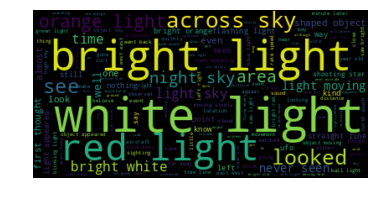

In [75]:
text = " ".join(t for t in sightings_cleaned.Detail_Summary_nltk.astype(str))
wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()

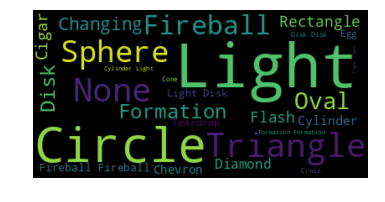

In [81]:
text = " ".join(t for t in sightings_cleaned.Shape.astype(str))
wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()